In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.io import arff
from io import BytesIO

## Preprocess Datasets - Child
### Read data file

In [2]:
# Read file
data = arff.loadarff('Autism-Child-Data.arff')
df_child = pd.DataFrame(data[0])
df_child.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Others',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
1,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Middle Eastern ',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
2,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'0',b'0',...,b'm',b'?',b'no',b'no',b'Jordan',b'yes',5.0,b'4-11 years',b'?',b'NO'
3,b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',...,b'f',b'?',b'yes',b'no',b'Jordan',b'no',4.0,b'4-11 years',b'?',b'NO'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',...,b'm',b'Others',b'yes',b'no',b'United States',b'no',10.0,b'4-11 years',b'Parent',b'YES'


In [3]:
df_child_drop = df_child.drop(['ethnicity','contry_of_res', 'age_desc'], axis=1)
df_child.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Others',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
1,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',...,b'm',b'Middle Eastern ',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
2,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'0',b'0',...,b'm',b'?',b'no',b'no',b'Jordan',b'yes',5.0,b'4-11 years',b'?',b'NO'
3,b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',...,b'f',b'?',b'yes',b'no',b'Jordan',b'no',4.0,b'4-11 years',b'?',b'NO'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',...,b'm',b'Others',b'yes',b'no',b'United States',b'no',10.0,b'4-11 years',b'Parent',b'YES'


In [4]:
for key in df_child_drop.columns.values.tolist():
    if (type(df_child_drop[key][0])==bytes):
        df_child_drop[key] = df_child_drop[key].str.decode('utf-8')
df_child_drop.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,m,no,no,no,5.0,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,6.0,m,no,no,no,5.0,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,6.0,m,no,no,yes,5.0,?,NO
3,0,1,0,0,1,1,0,0,0,1,5.0,f,yes,no,no,4.0,?,NO
4,1,1,1,1,1,1,1,1,1,1,5.0,m,yes,no,no,10.0,Parent,YES


In [5]:
for key in df_child_drop.columns.values.tolist():
    print(key + " has value: ", df_child_drop[key].unique())

A1_Score has value:  ['1' '0']
A2_Score has value:  ['1' '0']
A3_Score has value:  ['0' '1']
A4_Score has value:  ['0' '1']
A5_Score has value:  ['1' '0']
A6_Score has value:  ['1' '0']
A7_Score has value:  ['0' '1']
A8_Score has value:  ['1' '0']
A9_Score has value:  ['0' '1']
A10_Score has value:  ['0' '1']
age has value:  [ 6.  5.  4. 11. 10.  8.  7.  9. nan]
gender has value:  ['m' 'f']
jundice has value:  ['no' 'yes']
austim has value:  ['no' 'yes']
used_app_before has value:  ['no' 'yes']
result has value:  [ 5.  4. 10.  7.  8.  3.  9.  2.  1.  6.  0.]
relation has value:  ['Parent' '?' 'Self' 'Relative' 'Health care professional' 'self']
Class/ASD has value:  ['NO' 'YES']


In [6]:
df_child_drop['gender'] = df_child_drop['gender'].map({'m': 0, 'f': 1})
df_child_drop['jundice'] = df_child_drop['jundice'].map({'no': 0, 'yes': 1})
df_child_drop['austim'] = df_child_drop['austim'].map({'no': 0, 'yes': 1})
df_child_drop['used_app_before'] = df_child_drop['used_app_before'].map({'no': 0, 'yes': 1})
df_child_drop['relation'] = df_child_drop['relation'].map({'Parent': 0, 'Self': 1, 'self': 1, 'Relative': 2, 'Health care professional': 3, 'Others':4, '?': 0})
df_child_drop['Class/ASD'] = df_child_drop['Class/ASD'].map({'NO': 0, 'YES': 1})
df_child_drop.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,5.0,0,0
1,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,5.0,0,0
2,1,1,0,0,0,1,1,1,0,0,6.0,0,0,0,1,5.0,0,0
3,0,1,0,0,1,1,0,0,0,1,5.0,1,1,0,0,4.0,0,0
4,1,1,1,1,1,1,1,1,1,1,5.0,0,1,0,0,10.0,0,1


In [7]:
df_child_drop['age'].fillna(round(df_child_drop['age'].mean()), inplace=True)

In [8]:
df_child_drop['age'].unique()

array([ 6.,  5.,  4., 11., 10.,  8.,  7.,  9.])

In [9]:
# Some of the data are string not int, we will change it here
for key in df_child_drop.columns.values.tolist():        # loop though all entries           
    if (type(df_child_drop[key][0]) != int):             # Find non int data
        df_child_drop[key] = df_child_drop[key].astype(int)    # Change it to int

# Check dtype again
df_child_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         292 non-null    int32
 1   A2_Score         292 non-null    int32
 2   A3_Score         292 non-null    int32
 3   A4_Score         292 non-null    int32
 4   A5_Score         292 non-null    int32
 5   A6_Score         292 non-null    int32
 6   A7_Score         292 non-null    int32
 7   A8_Score         292 non-null    int32
 8   A9_Score         292 non-null    int32
 9   A10_Score        292 non-null    int32
 10  age              292 non-null    int32
 11  gender           292 non-null    int32
 12  jundice          292 non-null    int32
 13  austim           292 non-null    int32
 14  used_app_before  292 non-null    int32
 15  result           292 non-null    int32
 16  relation         292 non-null    int32
 17  Class/ASD        292 non-null    int32
dtypes: int32(1

In [10]:
df_child_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         292 non-null    int32
 1   A2_Score         292 non-null    int32
 2   A3_Score         292 non-null    int32
 3   A4_Score         292 non-null    int32
 4   A5_Score         292 non-null    int32
 5   A6_Score         292 non-null    int32
 6   A7_Score         292 non-null    int32
 7   A8_Score         292 non-null    int32
 8   A9_Score         292 non-null    int32
 9   A10_Score        292 non-null    int32
 10  age              292 non-null    int32
 11  gender           292 non-null    int32
 12  jundice          292 non-null    int32
 13  austim           292 non-null    int32
 14  used_app_before  292 non-null    int32
 15  result           292 non-null    int32
 16  relation         292 non-null    int32
 17  Class/ASD        292 non-null    int32
dtypes: int32(1

In [11]:
x_child = df_child_drop.copy().drop('Class/ASD', axis=1)
y_child = df_child_drop.copy()['Class/ASD']

In [12]:
x_child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         292 non-null    int32
 1   A2_Score         292 non-null    int32
 2   A3_Score         292 non-null    int32
 3   A4_Score         292 non-null    int32
 4   A5_Score         292 non-null    int32
 5   A6_Score         292 non-null    int32
 6   A7_Score         292 non-null    int32
 7   A8_Score         292 non-null    int32
 8   A9_Score         292 non-null    int32
 9   A10_Score        292 non-null    int32
 10  age              292 non-null    int32
 11  gender           292 non-null    int32
 12  jundice          292 non-null    int32
 13  austim           292 non-null    int32
 14  used_app_before  292 non-null    int32
 15  result           292 non-null    int32
 16  relation         292 non-null    int32
dtypes: int32(17)
memory usage: 19.5 KB


In [13]:
y_child.info()

<class 'pandas.core.series.Series'>
RangeIndex: 292 entries, 0 to 291
Series name: Class/ASD
Non-Null Count  Dtype
--------------  -----
292 non-null    int32
dtypes: int32(1)
memory usage: 1.3 KB


## Preprocess Datasets - Adolescent
### Read data file

In [14]:
# Read file
data = arff.loadarff('Autism-Adolescent-Data.arff')
df_adol = pd.DataFrame(data[0])
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'0',b'0',b'0',b'1',b'1',b'1',b'1',b'1',b'1',b'0',...,b'm',b'Hispanic',b'yes',b'yes',b'Austria',b'no',6.0,b'12-16 years',b'Parent',b'NO'
1,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',...,b'm',b'Black',b'no',b'no',b'Austria',b'no',2.0,b'12-16 years',b'Relative',b'NO'
2,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',...,b'f',b'?',b'no',b'no',b'AmericanSamoa',b'no',2.0,b'12-16 years',b'?',b'NO'
3,b'0',b'1',b'1',b'1',b'1',b'1',b'0',b'1',b'1',b'0',...,b'f',b'White-European',b'no',b'no',b'United Kingdom',b'no',7.0,b'12-16 years',b'Self',b'YES'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'0',b'0',b'0',...,b'f',b'?',b'no',b'no',b'Albania',b'no',7.0,b'12-16 years',b'?',b'YES'


### Sanity check

In [15]:
df_adol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         104 non-null    object 
 1   A2_Score         104 non-null    object 
 2   A3_Score         104 non-null    object 
 3   A4_Score         104 non-null    object 
 4   A5_Score         104 non-null    object 
 5   A6_Score         104 non-null    object 
 6   A7_Score         104 non-null    object 
 7   A8_Score         104 non-null    object 
 8   A9_Score         104 non-null    object 
 9   A10_Score        104 non-null    object 
 10  age              104 non-null    float64
 11  gender           104 non-null    object 
 12  ethnicity        104 non-null    object 
 13  jundice          104 non-null    object 
 14  austim           104 non-null    object 
 15  contry_of_res    104 non-null    object 
 16  used_app_before  104 non-null    object 
 17  result          

### Remove the entries, which we are not interessed

In [16]:
df_adol = df_adol.drop(['ethnicity', 'contry_of_res', 'age_desc'], axis=1)
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,b'0',b'0',b'0',b'1',b'1',b'1',b'1',b'1',b'1',b'0',15.0,b'm',b'yes',b'yes',b'no',6.0,b'Parent',b'NO'
1,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',15.0,b'm',b'no',b'no',b'no',2.0,b'Relative',b'NO'
2,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',12.0,b'f',b'no',b'no',b'no',2.0,b'?',b'NO'
3,b'0',b'1',b'1',b'1',b'1',b'1',b'0',b'1',b'1',b'0',14.0,b'f',b'no',b'no',b'no',7.0,b'Self',b'YES'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'0',b'0',b'0',16.0,b'f',b'no',b'no',b'no',7.0,b'?',b'YES'


### Decode

In [17]:
for key in df_adol.columns.values.tolist():                # loop through all entries of the dataframe
    if (type(df_adol[key][0])==bytes):                     # find bytes object
        df_adol[key] = df_adol[key].str.decode('utf-8')   # Decode and replace
df_adol.head()                                             # check

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,15.0,m,yes,yes,no,6.0,Parent,NO
1,0,0,0,0,0,0,0,0,1,1,15.0,m,no,no,no,2.0,Relative,NO
2,0,0,0,0,0,0,0,0,1,1,12.0,f,no,no,no,2.0,?,NO
3,0,1,1,1,1,1,0,1,1,0,14.0,f,no,no,no,7.0,Self,YES
4,1,1,1,1,1,1,1,0,0,0,16.0,f,no,no,no,7.0,?,YES


### One-Hot-Encoding

In [18]:
for key in df_adol.columns.values.tolist():
    print(key + " has value: ", df_adol[key].unique())

A1_Score has value:  ['0' '1']
A2_Score has value:  ['0' '1']
A3_Score has value:  ['0' '1']
A4_Score has value:  ['1' '0']
A5_Score has value:  ['1' '0']
A6_Score has value:  ['1' '0']
A7_Score has value:  ['1' '0']
A8_Score has value:  ['1' '0']
A9_Score has value:  ['1' '0']
A10_Score has value:  ['0' '1']
age has value:  [15. 12. 14. 16. 13.]
gender has value:  ['m' 'f']
jundice has value:  ['yes' 'no']
austim has value:  ['yes' 'no']
used_app_before has value:  ['no' 'yes']
result has value:  [ 6.  2.  7.  3.  4.  5.  9.  8. 10.  1.]
relation has value:  ['Parent' 'Relative' '?' 'Self' 'Health care professional' 'Others']
Class/ASD has value:  ['NO' 'YES']


In [19]:
df_adol['gender'] = df_adol['gender'].map({'m': 0, 'f': 1})
df_adol['jundice'] = df_adol['jundice'].map({'no': 0, 'yes': 1})
df_adol['austim'] = df_adol['austim'].map({'no': 0, 'yes': 1})
df_adol['used_app_before'] = df_adol['used_app_before'].map({'no': 0, 'yes': 1})
df_adol['relation'] = df_adol['relation'].map({'Parent': 0, 'Self': 1, 'Relative': 2, 'Health care professional': 3, 'Others':4, '?': 0})
df_adol['Class/ASD'] = df_adol['Class/ASD'].map({'NO': 0, 'YES': 1})
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,15.0,0,1,1,0,6.0,0,0
1,0,0,0,0,0,0,0,0,1,1,15.0,0,0,0,0,2.0,2,0
2,0,0,0,0,0,0,0,0,1,1,12.0,1,0,0,0,2.0,0,0
3,0,1,1,1,1,1,0,1,1,0,14.0,1,0,0,0,7.0,1,1
4,1,1,1,1,1,1,1,0,0,0,16.0,1,0,0,0,7.0,0,1


In [20]:
# Some of the data are string not int, we will change it here
for key in df_adol.columns.values.tolist():        # loop though all entries           
    if (type(df_adol[key][0]) != int):             # Find non int data
        df_adol[key] = df_adol[key].astype(int)    # Change it to int

# Check dtype again
df_adol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         104 non-null    int32
 1   A2_Score         104 non-null    int32
 2   A3_Score         104 non-null    int32
 3   A4_Score         104 non-null    int32
 4   A5_Score         104 non-null    int32
 5   A6_Score         104 non-null    int32
 6   A7_Score         104 non-null    int32
 7   A8_Score         104 non-null    int32
 8   A9_Score         104 non-null    int32
 9   A10_Score        104 non-null    int32
 10  age              104 non-null    int32
 11  gender           104 non-null    int32
 12  jundice          104 non-null    int32
 13  austim           104 non-null    int32
 14  used_app_before  104 non-null    int32
 15  result           104 non-null    int32
 16  relation         104 non-null    int32
 17  Class/ASD        104 non-null    int32
dtypes: int32(1

In [21]:
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,15,0,1,1,0,6,0,0
1,0,0,0,0,0,0,0,0,1,1,15,0,0,0,0,2,2,0
2,0,0,0,0,0,0,0,0,1,1,12,1,0,0,0,2,0,0
3,0,1,1,1,1,1,0,1,1,0,14,1,0,0,0,7,1,1
4,1,1,1,1,1,1,1,0,0,0,16,1,0,0,0,7,0,1


### Split the data into training and testing set

In [22]:
# Split to data and labels
X = df_adol.copy().drop(['Class/ASD'], axis=1)
y = df_adol.copy()['Class/ASD']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Size of Training Set: ", len(X_train))
print("Size of Testing Set: ", len(X_test))


Size of Training Set:  72
Size of Testing Set:  32


### Train a model

In [23]:
# Creat a random forest model
clf = RandomForestClassifier(n_estimators=1000)

In [24]:
# Train
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [25]:
# Test accuracy
y_pred = clf.predict(X_test)
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Validate on children dataset

In [26]:
# Test accuracy
child_pred = clf.predict(x_child)
print("Accuracy:",sklearn.metrics.accuracy_score(y_child, child_pred))

Accuracy: 1.0


### Feature Ranking

In [27]:
importance = clf.feature_importances_
index = np.argsort(clf.feature_importances_).tolist()
std = np.std([tree.feature_importances_[index] for tree in clf.estimators_], axis=0)
# feature_ranking = pd.Series(importance, index=X.columns.values.tolist())
# fig, ax = plt.subplots()
# feature_ranking.plot.bar(yerr=std, ax=ax)

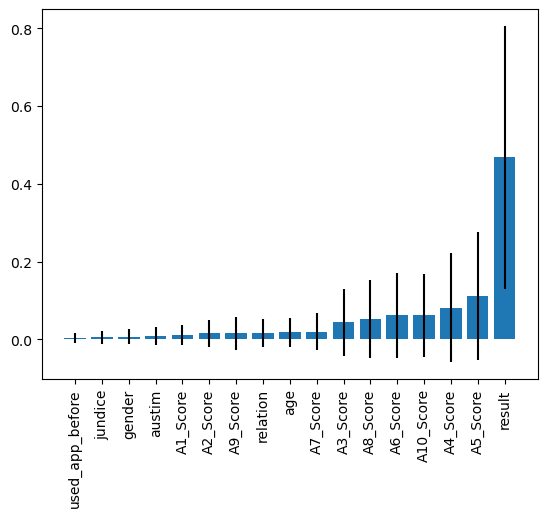

In [28]:
fig, ax = plt.subplots()
ax = plt.bar(X_train.columns[index], clf.feature_importances_[index], yerr=std)
plt.xticks(rotation=90)
plt.show()


In [29]:
# Creat a random forest model
clf = RandomForestClassifier(n_estimators=6)

### Dropout features

In [67]:
labels_to_drop = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 
'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
n_estimator = 100
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3)
clf = RandomForestClassifier(n_estimators=n_estimator)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))

Dropped features:  ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
Used features ['result']
Accuracy: 1.0


Dropped features:  ['result']
Used features ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'jundice', 'austim', 'used_app_before', 'relation']
Accuracy: 0.90625


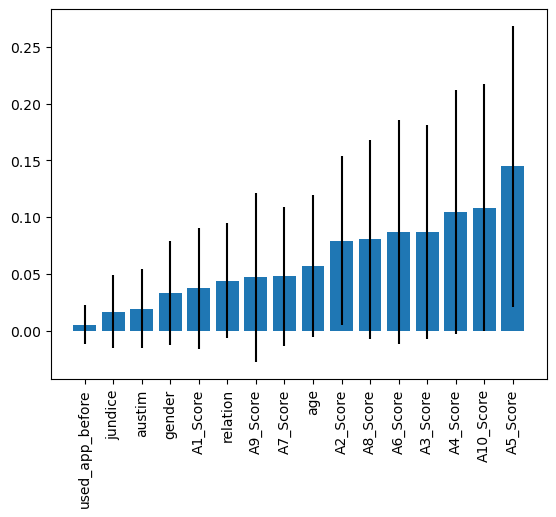

In [69]:
labels_to_drop = ['result']
n_estimator = 1000
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3)
clf = RandomForestClassifier(n_estimators=n_estimator)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
importance = clf.feature_importances_
index = np.argsort(importance).tolist()
std = np.std([tree.feature_importances_[index] for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
ax = plt.bar(X_train.columns[index], importance[index], yerr=std)
plt.xticks(rotation=90)
plt.show()

Dropped features:  ['result', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
Used features ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Accuracy: 0.8125


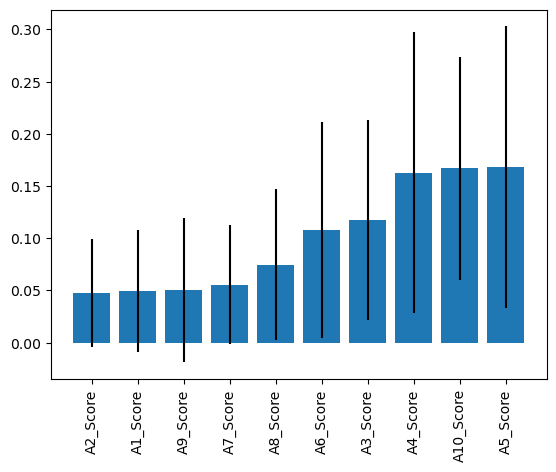

In [68]:
labels_to_drop = ['result', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
n_estimator = 1000
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3)
clf = RandomForestClassifier(n_estimators=n_estimator)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
importance = clf.feature_importances_
index = np.argsort(importance).tolist()
std = np.std([tree.feature_importances_[index] for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
ax = plt.bar(X_train.columns[index], importance[index], yerr=std)
plt.xticks(rotation=90)
plt.show()

Dropped features:  ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
Used features ['age', 'gender', 'jundice', 'austim', 'used_app_before', 'relation']
Accuracy: 0.6875


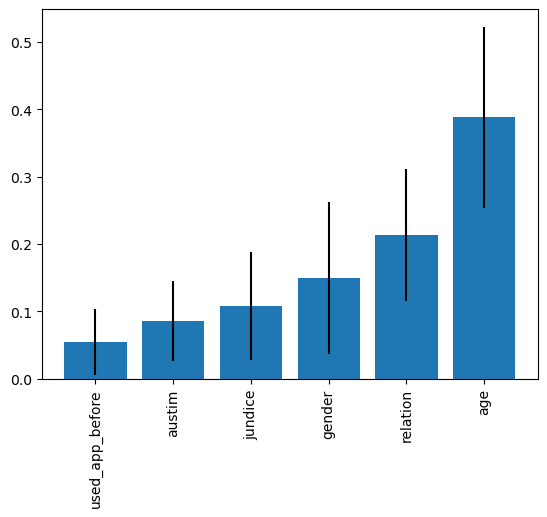

In [70]:
labels_to_drop = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
n_estimator = 100
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3)
clf = RandomForestClassifier(n_estimators=n_estimator)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
importance = clf.feature_importances_
index = np.argsort(importance).tolist()
std = np.std([tree.feature_importances_[index] for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
ax = plt.bar(X_train.columns[index], importance[index], yerr=std)
plt.xticks(rotation=90)
plt.show()

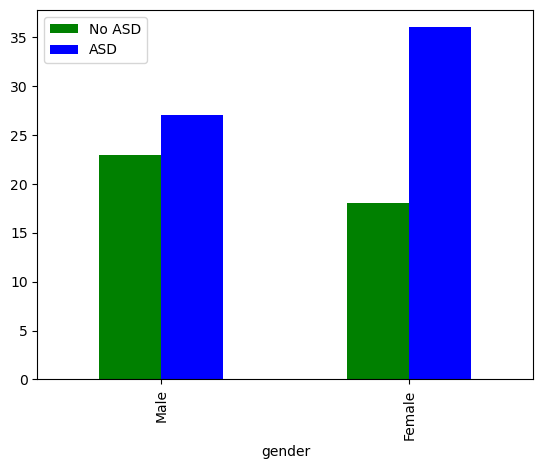

In [96]:
crosstab_result=pd.crosstab(index=df_adol['gender'],columns=df_adol['Class/ASD'])
fig, ax = plt.subplots()
crosstab_result.plot.bar(color=['g', 'b'], ax=ax)
ax.set_xticks([0,1], ['Male', 'Female'])
ax.legend(labels=['No ASD', 'ASD'])

In [91]:
ax.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),